# Forecasting 

![extrapolating](https://imgs.xkcd.com/comics/extrapolating.png)

In this lesson, we will practice forecasting using the following methods:  

- Last Observed Value  
- Simple Average  
- Moving Average
- Previous Cycle 
- Holt's Linear Trend
- Holt's Seasonal Trend
 

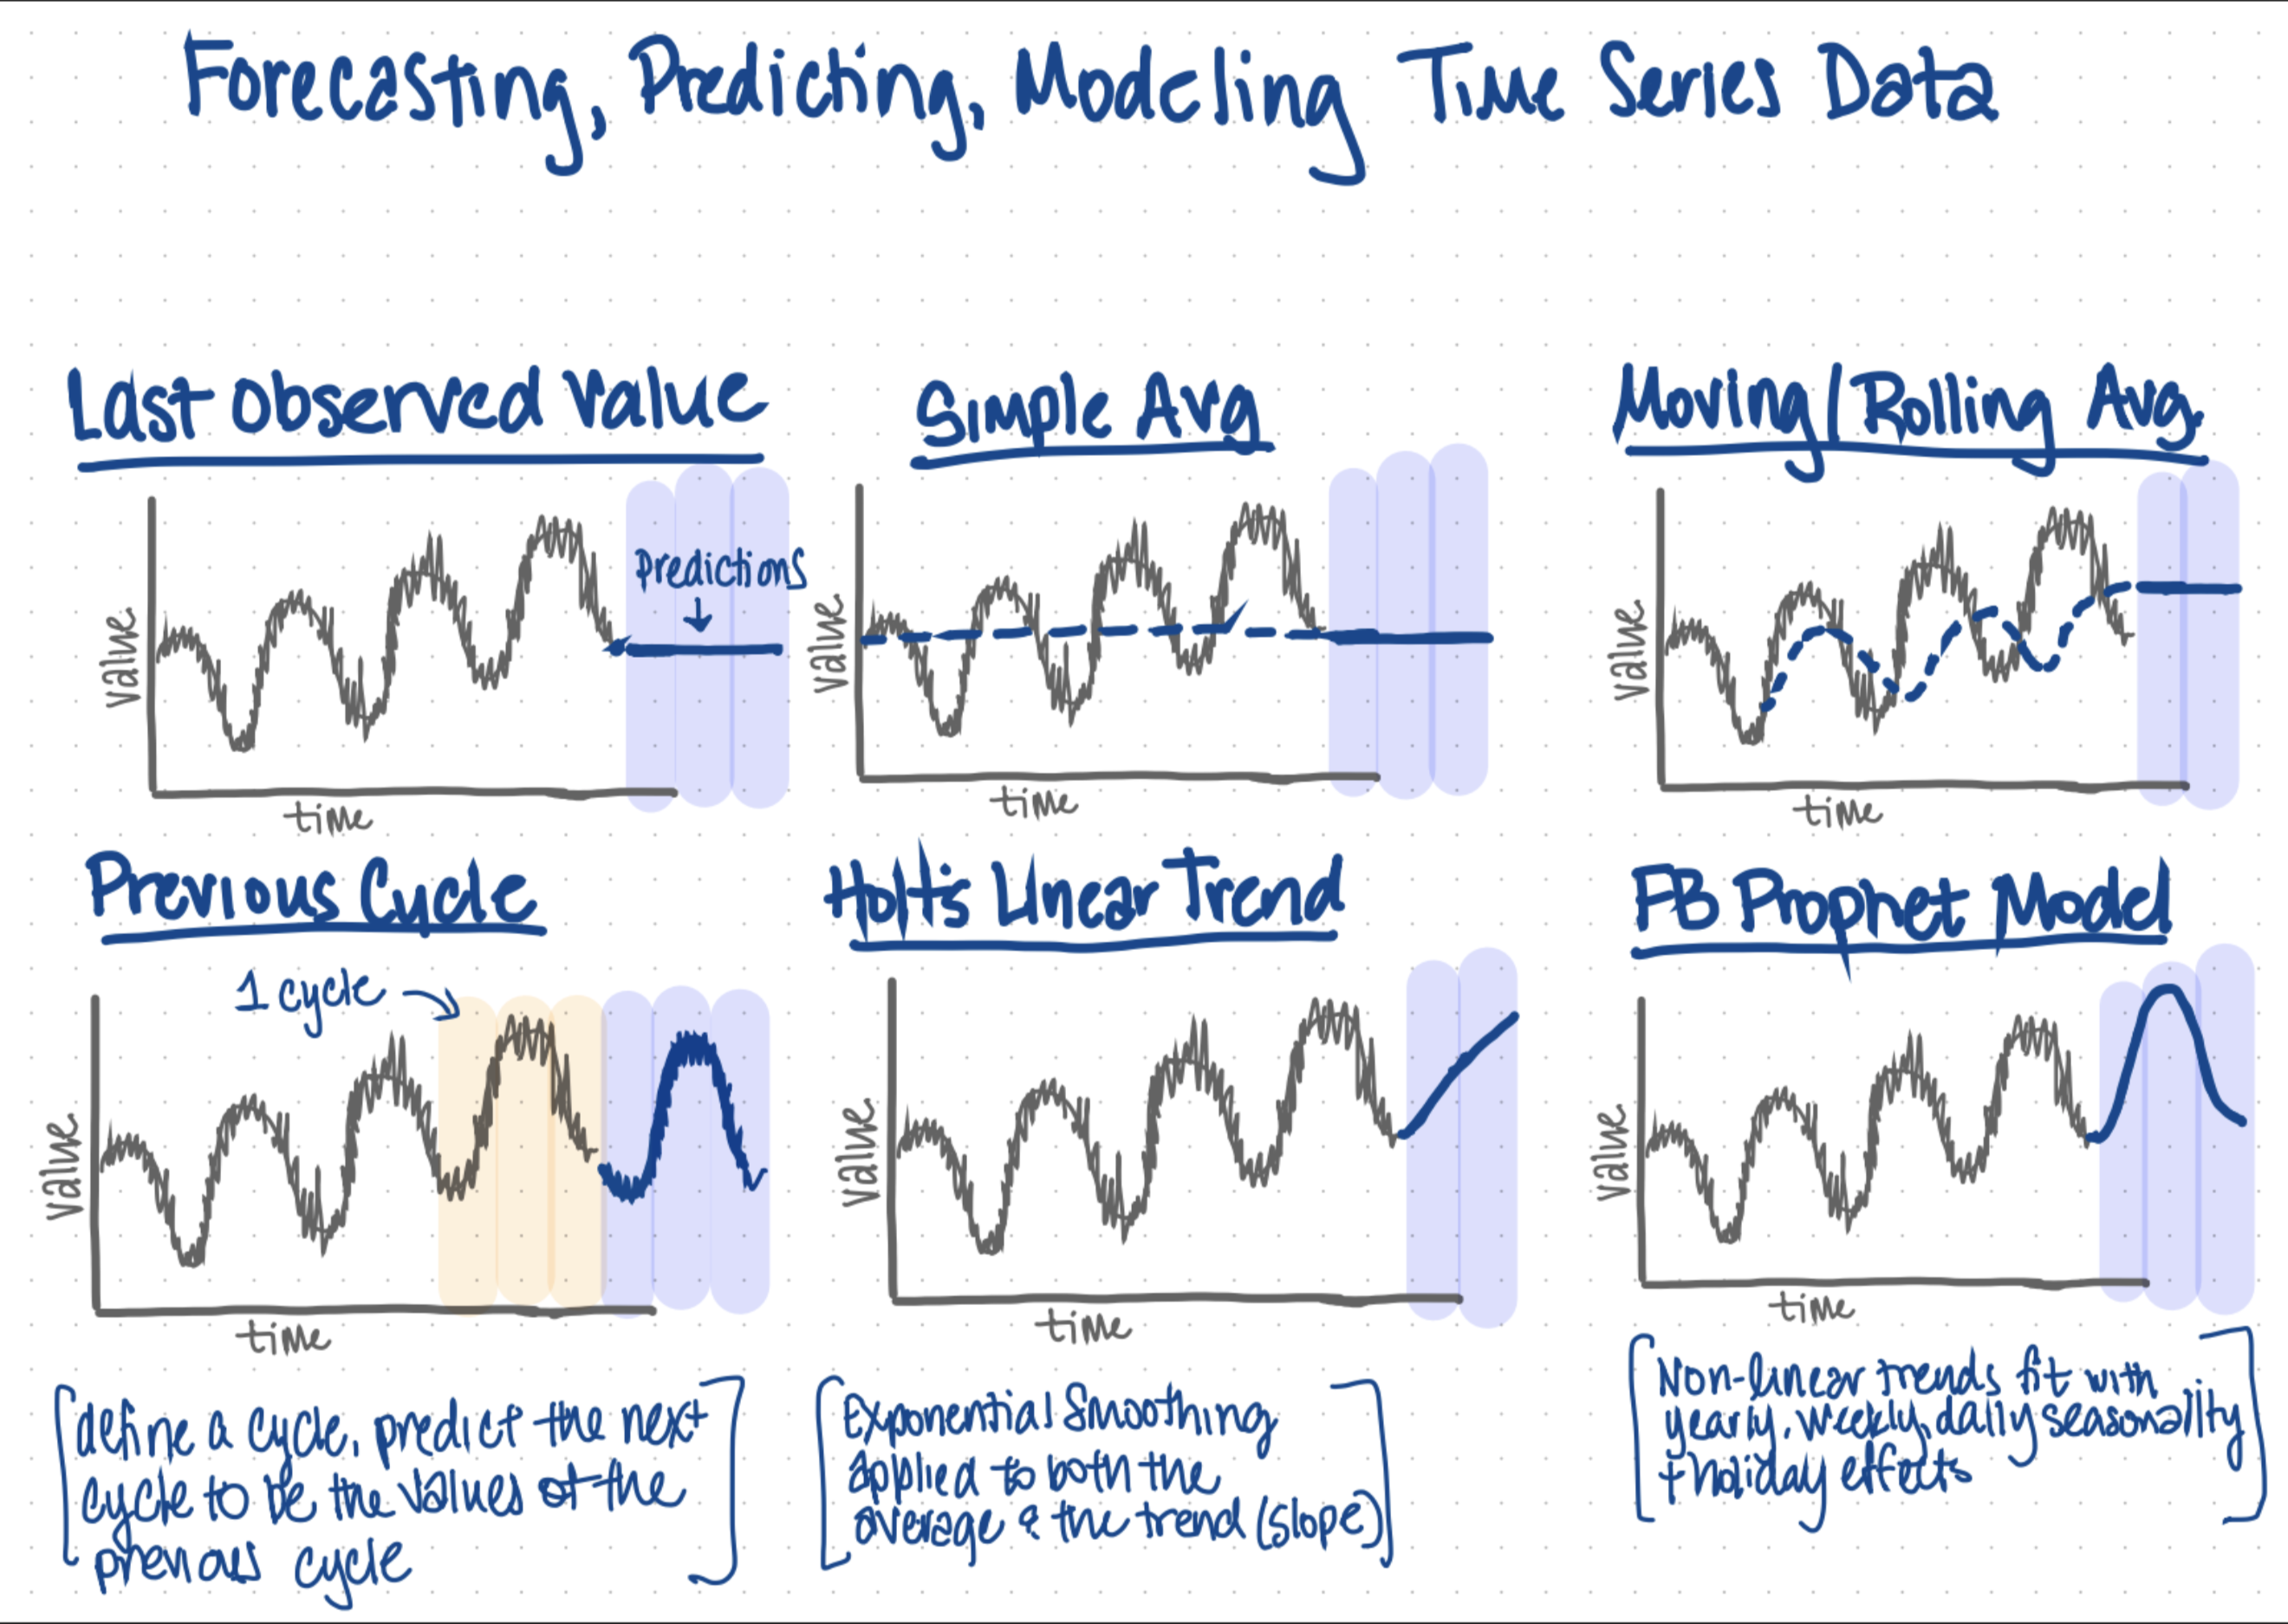


In this lesson we will:
- Acquire and prepare store sales data stored in our Codeup MySQL server.
- Forecast future values using each modeling approach.
- Evaluate competing model performance.

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

## Wrangle

We will acquire the data from our MySQL server and cache a local .csv version of our data if it is not already present.
 

In [2]:
df = acquire.get_store_data()
df = prepare.prep_store_data(df)

In [3]:
df.head(2)

store_id  item_id  sale_id  quantity   item_upc14   item_upc12  \
sale_date                                                                    
2013-01-01         1        1        1        13  35200264013  35200264013   
2013-01-01         7       12   211817        26  74676640211  74676640211   

           item_brand                                          item_name  \
sale_date                                                                  
2013-01-01   Riceland                     Riceland American Jazmine Rice   
2013-01-01    Mueller  Mueller Sport Care Basic Support Level Medium ...   

            item_price           store_address  store_zipcode   store_city  \
sale_date                                                                    
2013-01-01        0.84  12125 Alamo Ranch Pkwy          78253  San Antonio   
2013-01-01        8.40  12018 Perrin Beitel Rd          78217  San Antonio   

           store_state   month    dow  sales_total  
sale_date                                           
2013-01-01          TX  01-Jan  2-Tue        10.92  
2013-01-01          TX  01-Jan  2-Tue       218.40

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   store_id       913000 non-null  int64  
 1   item_id        913000 non-null  int64  
 2   sale_id        913000 non-null  int64  
 3   quantity       913000 non-null  int64  
 4   item_upc14     913000 non-null  int64  
 5   item_upc12     913000 non-null  int64  
 6   item_brand     913000 non-null  object 
 7   item_name      913000 non-null  object 
 8   item_price     913000 non-null  float64
 9   store_address  913000 non-null  object 
 10  store_zipcode  913000 non-null  int64  
 11  store_city     913000 non-null  object 
 12  store_state    913000 non-null  object 
 13  month          913000 non-null  object 
 14  dow            913000 non-null  object 
 15  sales_total    913000 non-null  float64
dtypes: float64(2), int64(7), object(7)
memory usage: 118.4+ MB

## Prepare

1. Confirm our approach using `.head()`, `.info()`, and `.describe()`.
1. Resample to a daily period.
1. Drop the leap year days

### Preliminary Data Cleaning

Let's take a look at our data:

In [5]:
df.head(3)

store_id  item_id  sale_id  quantity   item_upc14   item_upc12  \
sale_date                                                                    
2013-01-01         1        1        1        13  35200264013  35200264013   
2013-01-01         7       12   211817        26  74676640211  74676640211   
2013-01-01         7       46   832657        27  35457770664  35457770664   

            item_brand                                          item_name  \
sale_date                                                                   
2013-01-01    Riceland                     Riceland American Jazmine Rice   
2013-01-01     Mueller  Mueller Sport Care Basic Support Level Medium ...   
2013-01-01  Mama Marys                                        Pizza Sauce   

            item_price           store_address  store_zipcode   store_city  \
sale_date                                                                    
2013-01-01        0.84  12125 Alamo Ranch Pkwy          78253  San Antonio   
2013-01-01        8.40  12018 Perrin Beitel Rd          78217  San Antonio   
2013-01-01        4.65  12018 Perrin Beitel Rd          78217  San Antonio   

           store_state   month    dow  sales_total  
sale_date                                           
2013-01-01          TX  01-Jan  2-Tue        10.92  
2013-01-01          TX  01-Jan  2-Tue       218.40  
2013-01-01          TX  01-Jan  2-Tue       125.55

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   store_id       913000 non-null  int64  
 1   item_id        913000 non-null  int64  
 2   sale_id        913000 non-null  int64  
 3   quantity       913000 non-null  int64  
 4   item_upc14     913000 non-null  int64  
 5   item_upc12     913000 non-null  int64  
 6   item_brand     913000 non-null  object 
 7   item_name      913000 non-null  object 
 8   item_price     913000 non-null  float64
 9   store_address  913000 non-null  object 
 10  store_zipcode  913000 non-null  int64  
 11  store_city     913000 non-null  object 
 12  store_state    913000 non-null  object 
 13  month          913000 non-null  object 
 14  dow            913000 non-null  object 
 15  sales_total    913000 non-null  float64
dtypes: float64(2), int64(7), object(7)
memory usage: 118.4+ MB

In [7]:
df.describe()

store_id        item_id        sale_id       quantity  \
count  913000.000000  913000.000000  913000.000000  913000.000000   
mean        5.500000      25.500000  456500.500000      52.250287   
std         2.872283      14.430878  263560.542223      28.801144   
min         1.000000       1.000000       1.000000       0.000000   
25%         3.000000      13.000000  228250.750000      30.000000   
50%         5.500000      25.500000  456500.500000      47.000000   
75%         8.000000      38.000000  684750.250000      70.000000   
max        10.000000      50.000000  913000.000000     231.000000   

         item_upc14    item_upc12     item_price  store_zipcode    sales_total  
count  9.130000e+05  9.130000e+05  913000.000000  913000.000000  913000.000000  
mean   2.384688e+11  2.384688e+11       5.160400   78224.800000     280.898866  
std    2.978005e+11  2.978005e+11       2.737764      16.479087     227.686575  
min    8.500005e+09  8.500005e+09       0.600000   78201.000000       0.000000  
25%    3.367410e+10  3.367410e+10       2.970000   78217.000000      98.010000  
50%    7.103651e+10  7.103651e+10       5.195000   78220.500000     233.280000  
75%    6.030842e+11  6.030842e+11       7.520000   78232.000000     402.780000  
max    8.846237e+11  8.846237e+11       9.640000   78253.000000    2104.410000

We will resample to daily aggregating our values using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores. 

In [8]:
# resample by day, sum
df_resampled = df.resample('d')[['quantity', 'sales_total']].sum()

In [9]:
df_resampled.head(2)

quantity  sales_total
sale_date                        
2013-01-01     13696     73844.01
2013-01-02     13678     73570.58

In [10]:
df_resampled.shape

(1826, 2)

In [11]:
df_resampled.loc['2016-02-29']

quantity       16916.00
sales_total    90944.03
Name: 2016-02-29 00:00:00, dtype: float64

In [12]:
# Drop February 29th from our dataset (a leap year date)
# we do have a leap day in this data set, so I'm going
# to drop it out so it doesn't disrupt our annual cycle/365 count
df_resampled = df_resampled[df_resampled.index != '2016-02-29']

In [13]:
df_resampled.head(2)

quantity  sales_total
sale_date                        
2013-01-01     13696     73844.01
2013-01-02     13678     73570.58

## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiple by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [14]:
.5 * df_resampled.shape[0]

912.5

In [15]:
int(.5 * len(df_resampled))

912

In [16]:
# take 50% of our data for train (round to integer for a whole number)
train_size = int(.5 * len(df_resampled))

# take 30% for validation
validate_size = int(len(df_resampled) * .3)

# get the remainder of rows for test
test_size = int(len(df_resampled) - train_size - validate_size)

# get the delineation point between validate and test by summing train and validate
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [17]:
train.shape[0] + validate.shape[0] + test.shape[0]

1825

## Visualizing Our Data

Let's plot our data first, viewing where the data is split into train and test. 

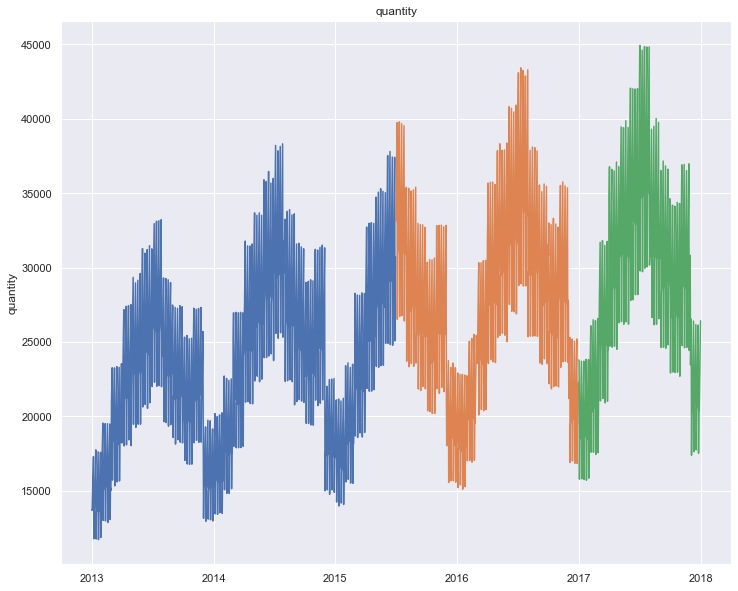

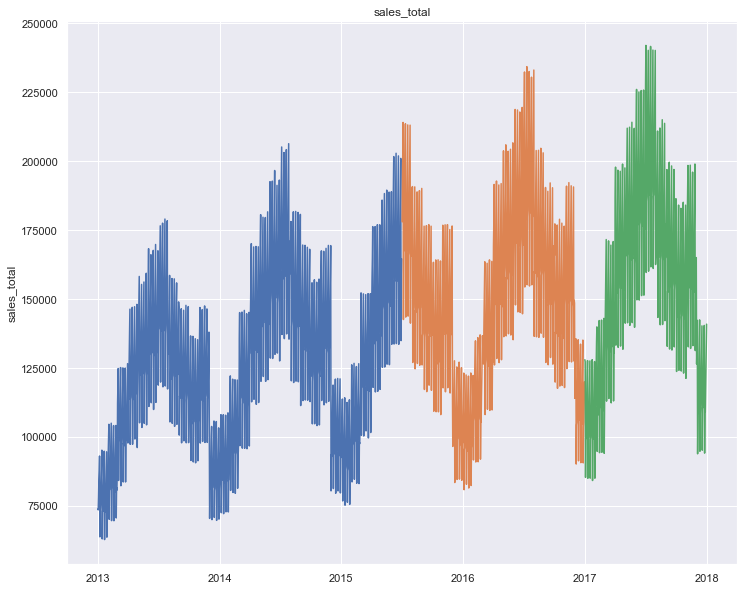

In [18]:
# plotting the values of quantity and sales over time by data subset:
for col in train.columns:
    plt.figure(figsize=(12,10))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Creating Helpful Evaluation Functions

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [19]:
# evaluation function to compute rmse
# calculate an error metric on the validation's target versus predictions
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(
        sqrt(
            mean_squared_error(
            validate[target_var],
            yhat_df[target_var])
        ), 0)
    return rmse

    

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to visualize our performance to make comparisons.

In [20]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var], label='Prediction', linewidth=1)
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'-- rmse: {round(rmse,2)}')
    plt.legend()
    plt.show()

We are planning on evaluating a lot of models. Let's create an easy to read dataframe called `eval_df`. We will eventually add the metrics we calculate for each of our models to this dataframe for easy comparison.

In [21]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

Empty DataFrame
Columns: [model_type, target_var, rmse]
Index: []

While we could manually append the performance results of each model to this dataframe, its better to create a function that will do it for us.

`append_eval_df()` will append evaluation metrics for each model into our eval_df data frame object. This function is dependent on `eval_df` already existing, which we accomplished in our previous step.

In [22]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    return pd.concat([eval_df, pd.DataFrame(d)])

## Forecast

Forecasting is another word for predicting time series data. As a reminder, we will work with the following approaches:

#### Baseline Models
1. Last Observed Value
2. Simple Average
3. Moving Average

#### Non-Baseline Models
4. Previous Cycle
5. Holt's Linear Trend
6. Holt's Seasonal Trend

### Last Observed Value

The simplest method for forecasting is to predict all future values to be the last observed value.  
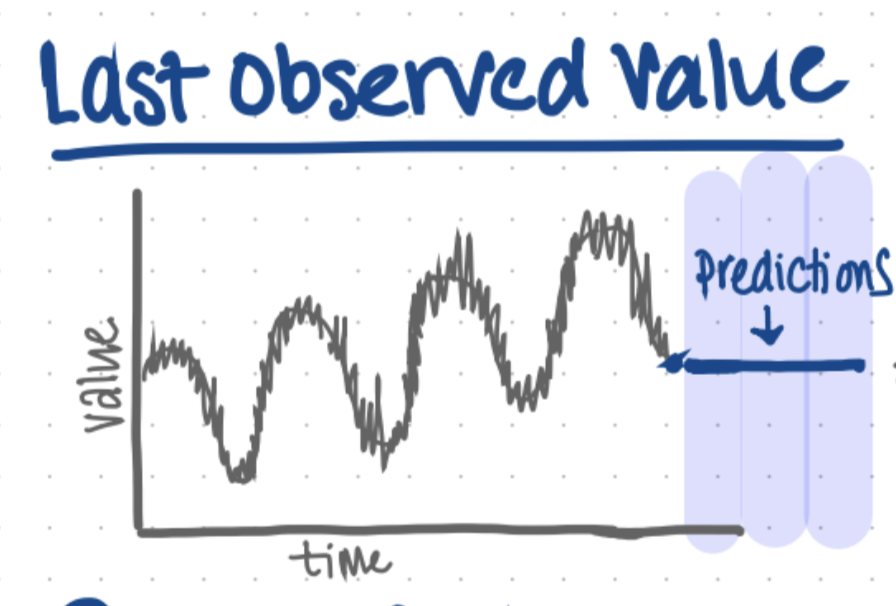

**Make Predictions**

In [23]:
# going forward from the -1st element in train's sales total, then 
# rip out the value associated with it by taking the zeroth element of that return
train['sales_total'][-1:][0]

164573.2

In [24]:
train

quantity  sales_total
sale_date                        
2013-01-01     13696     73844.01
2013-01-02     13678     73570.58
2013-01-03     14488     78169.48
2013-01-04     15677     84467.73
2013-01-05     16237     87621.85
...              ...          ...
2015-06-27     35251    189096.47
2015-06-28     37410    201002.82
2015-06-29     25074    134932.08
2015-06-30     29345    158904.06
2015-07-01     30703    164573.20

[912 rows x 2 columns]

In [25]:
# take the last item of sales total and assign to variable
# indexing: last thing to the end, then the first element
last_sales = train['sales_total'][-1:][0]

# take the last item of quantity and assign to variable
last_quantity = train['quantity'][-1:][0]

# let's make the prediction dataframe that we referenced a little earlier
yhat_df = pd.DataFrame(
    {
    'sales_total': [last_sales],
    'quantity': [last_quantity]
    },
    index = validate.index
)


In [26]:
yhat_df.head()

sales_total  quantity
sale_date                        
2015-07-02     164573.2     30703
2015-07-03     164573.2     30703
2015-07-04     164573.2     30703
2015-07-05     164573.2     30703
2015-07-06     164573.2     30703

You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values using our plot_and_eval() function:

quantity -- rmse: 6621.0


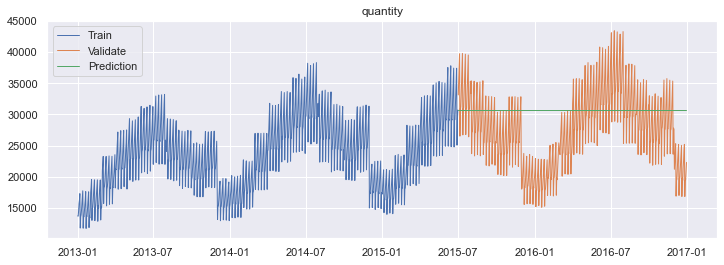

sales_total -- rmse: 35402.0


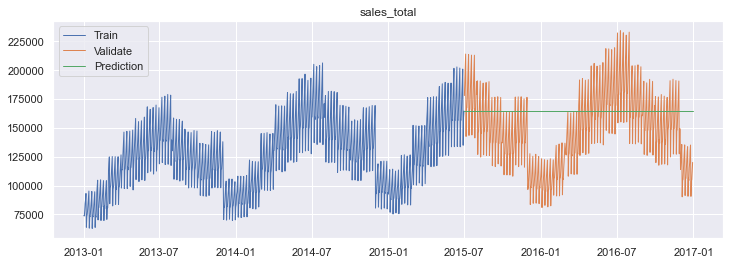

In [27]:
# use the plot and eval function we defined earlier for both targets:
for col in train.columns:
    plot_and_eval(col)

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`. We will add our metrics via our `append_eval_df()` function.

In [28]:
eval_df

Empty DataFrame
Columns: [model_type, target_var, rmse]
Index: []

In [29]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                             target_var=col)

In [30]:
eval_df

model_type   target_var     rmse
0  last_observed_value     quantity   6621.0
0  last_observed_value  sales_total  35402.0

### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 
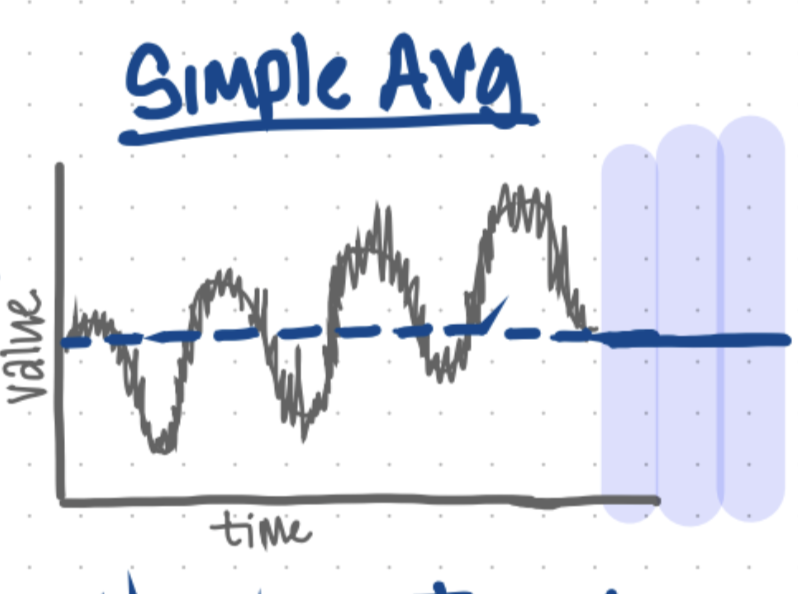

**Make Predictions**

In [31]:
# compute simple average of sales_total (from train data)
avg_sales = round(train['sales_total'].mean(), 2)

# compute simple average of quantity (from train data)
avg_quantity = round(train['quantity'].mean(), 2)


yhat_df = pd.DataFrame({'sales_total': [avg_sales],
                        'quantity': [avg_quantity]},
                        index=validate.index)

yhat_df.head(3)

sales_total  quantity
sale_date                        
2015-07-02    127517.85  23717.94
2015-07-03    127517.85  23717.94
2015-07-04    127517.85  23717.94

### Plot Actual vs. Predicted Values

Similar to our handling of the previous baseline model, we can plot our `yhat_df` values against the actual values in validate. Our `plot_and_eval` function accomplishes this.

quantity -- rmse: 7378.0


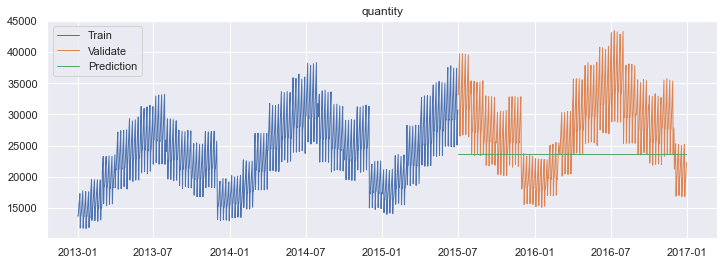

sales_total -- rmse: 39664.0


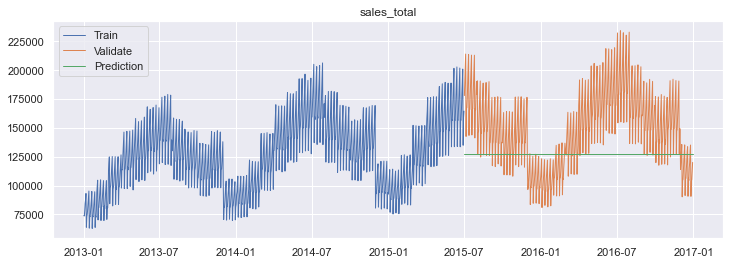

In [32]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [33]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

model_type   target_var     rmse
0  last_observed_value     quantity   6621.0
0  last_observed_value  sales_total  35402.0
0       simple_average     quantity   7378.0
0       simple_average  sales_total  39664.0

### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average of the last period, here 30-days, will be used as the forecasted value. 

> Moving averages are moving and change over time, but only historically. Forecasts using the moving average use the average of the last period/window of time.

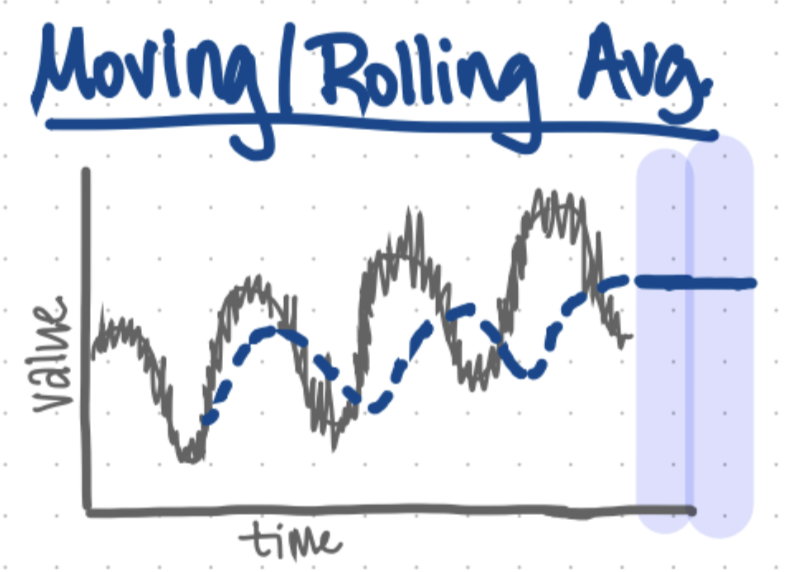

**Make Predictions**

There are several ways to obtain the mean of the last 30 periods in train. We will use the `.rolling()` method to accomplish this.

In [34]:
train['sales_total'].rolling(30).mean()[-1]

168957.912

In [35]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

rolling_sales = round(
    train['sales_total'].rolling(period).mean()[-1], 2)
rolling_quantity = round(
    train['quantity'].rolling(period).mean()[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'sales_total': rolling_sales,
                        'quantity': rolling_quantity},
                         index=validate.index)
yhat_df.head()

sales_total  quantity
sale_date                        
2015-07-02    168957.91  31432.77
2015-07-03    168957.91  31432.77
2015-07-04    168957.91  31432.77
2015-07-05    168957.91  31432.77
2015-07-06    168957.91  31432.77

**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

quantity -- rmse: 6954.0


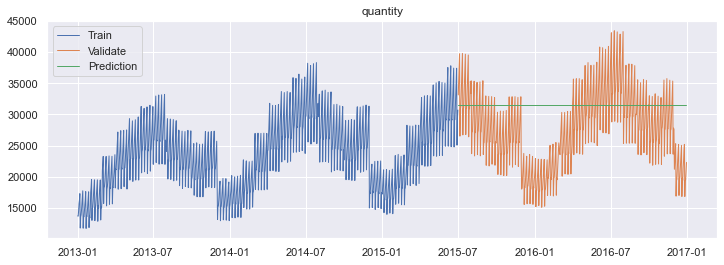

sales_total -- rmse: 37378.0


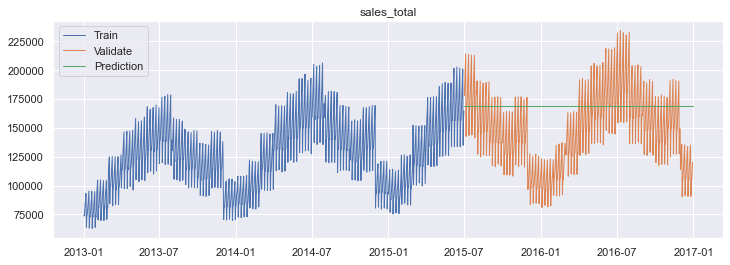

In [36]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [37]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)
eval_df

model_type   target_var     rmse
0  last_observed_value     quantity   6621.0
0  last_observed_value  sales_total  35402.0
0       simple_average     quantity   7378.0
0       simple_average  sales_total  39664.0
0   30d moving average     quantity   6954.0
0   30d moving average  sales_total  37378.0

Let's try out several other values for periods:

In [38]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(
    train['sales_total'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(
    train['quantity'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame(
        {
            'sales_total' : [rolling_sales],
            'quantity': [rolling_quantity]
        },
        index=validate.index
    )
    model_type = str(p) + '_day_moving_avg'
    # lets update the eval_df (remember we have two targets!)
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                 target_var = col)

In [39]:
eval_df

model_type   target_var     rmse
0  last_observed_value     quantity   6621.0
0  last_observed_value  sales_total  35402.0
0       simple_average     quantity   7378.0
0       simple_average  sales_total  39664.0
0   30d moving average     quantity   6954.0
0   30d moving average  sales_total  37378.0
0     4_day_moving_avg     quantity   6592.0
0     4_day_moving_avg  sales_total  35515.0
0    12_day_moving_avg     quantity   6992.0
0    12_day_moving_avg  sales_total  37644.0
0    26_day_moving_avg     quantity   7004.0
0    26_day_moving_avg  sales_total  37640.0
0    52_day_moving_avg     quantity   6563.0
0    52_day_moving_avg  sales_total  35322.0
0   104_day_moving_avg     quantity   6101.0
0   104_day_moving_avg  sales_total  32803.0

Which is best so far? : `104_day_moving_avg`

In [40]:
eval_df.groupby('target_var')['rmse'].min()

target_var
quantity        6101.0
sales_total    32803.0
Name: rmse, dtype: float64

In [41]:
# get the min rmse for each variable

min_rmse_sales_total = eval_df.groupby(
    'target_var')['rmse'].min()[1]

min_rmse_quantity = eval_df.groupby(
    'target_var')['rmse'].min()[0]

In [42]:
min_rmse_sales_total

32803.0

In [43]:
min_rmse_quantity

6101.0

In [44]:
eval_df[(eval_df.rmse == min_rmse_sales_total) | 
       (eval_df.rmse == min_rmse_quantity)]

model_type   target_var     rmse
0  104_day_moving_avg     quantity   6101.0
0  104_day_moving_avg  sales_total  32803.0

As far as baselines are concerned, it looks like our 104 day moving average is a good starting point for comparisons.
# Non-Baseline Models

## Holt-Winters
Two of the models that we will evaluate are based on Holt-Winters, which models on three elements:
- A typical value (average)
- A slope (trend) over time
- And a cyclical repeating pattern (seasonality)

Its worth looking at a seasonal decomposition plot of our target, to inspect these components:

#### Seasonal Decomposition

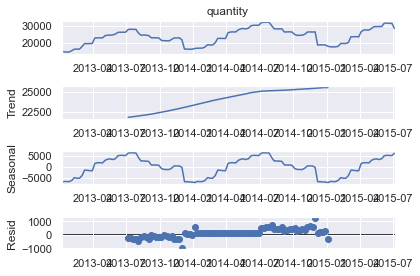

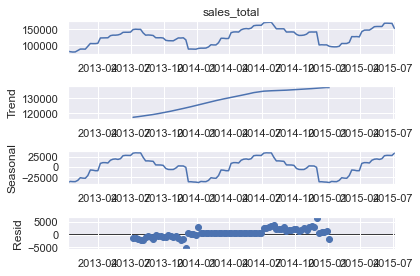

In [45]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()

It looks like there is both strong seasonality and a notable trend in both targets (`sales_total` and `quantity`). There are two Holt-Winters models that we will attempt
- Holt's Linear Trend
- Holt's Seasonal Model

### [Holt's Linear Trend]("https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.Holt.html")

Our approach will be similar to many other modeling processes we have performed:
1. Create the object: `Holt()`
2. Fit the object: `.fit()`
3. Make predictions: `.predict()`

The first set of hyperparameters are set when we call `Holt()`: 

- **exponential** = True/False (exponential vs. linear growth, additive vs. multiplicative)
- **damped $\phi$** = True/False
    - with Holt, forecasts tend to increase or decrease indefinitely into the future.  To avoid absurd long term predictions, use the Damped method (True) which sets a damping parameter between 0< ϕ <1. 

A second set of hyperparameters are set when we call `.fit()`: 

- **smoothing_level ($\alpha$)**: value between (0,1)
    - Closer to 0, the level doesn't change with each new observation
    - Closer to 1, the level reacts strongly with each new observation
- **smoothing_slope ($\beta$)**: value between (0,1)
    - Closer to 0, trend is not changing over time
    - Closer to 1, trend is changing significantly over time
- **optimized**: use the auto-optimization that allow statsmodels to automatically find an optimized value for us. 

#### Basic Holt's Linear Trend

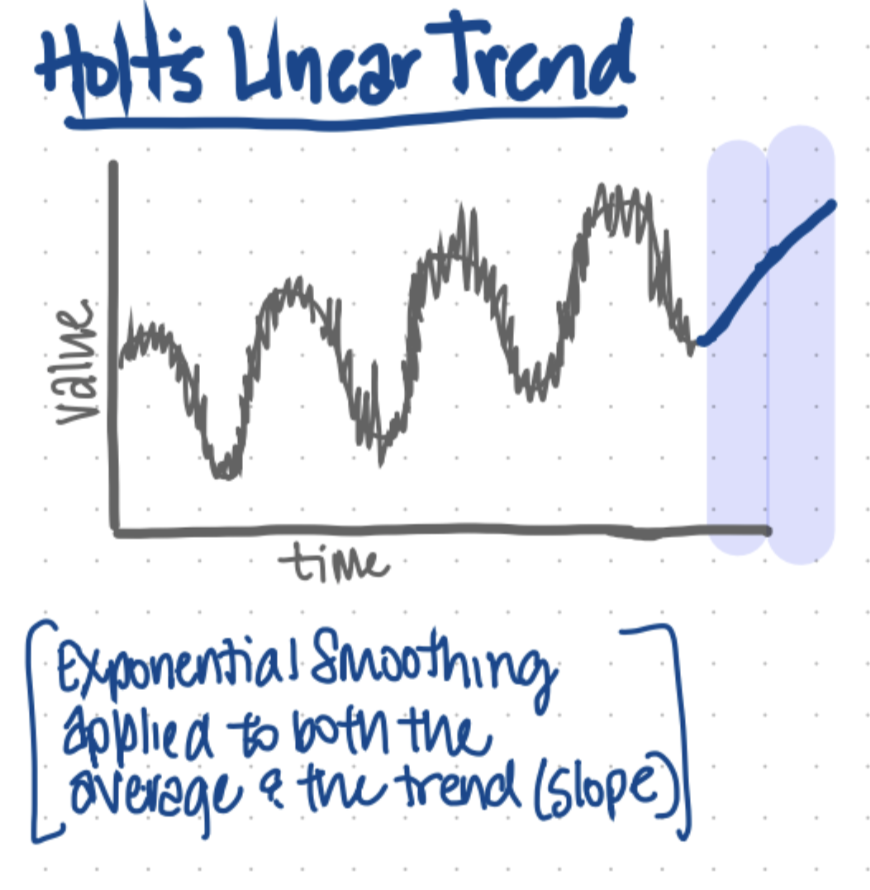
**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

In [46]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start=validate.index[0],
                                end= validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [47]:
yhat_df.head()

sales_total  quantity
sale_date                        
2015-07-02    170207.53  31656.49
2015-07-03    170328.01  31678.93
2015-07-04    170447.29  31701.15
2015-07-05    170565.37  31723.15
2015-07-06    170682.27  31744.93

**Plot Actual vs. Predicted Values**

quantity -- rmse: 8225.0


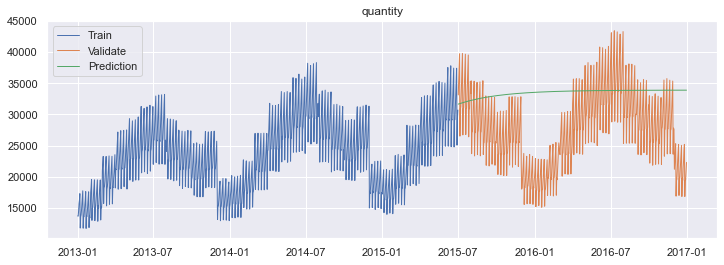

sales_total -- rmse: 44226.0


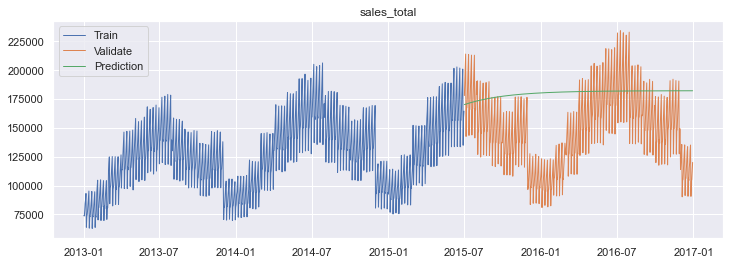

In [48]:
for col in train.columns:
    plot_and_eval(target_var = col)

**Evaluate**

In [49]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [50]:
eval_df

model_type   target_var     rmse
0  last_observed_value     quantity   6621.0
0  last_observed_value  sales_total  35402.0
0       simple_average     quantity   7378.0
0       simple_average  sales_total  39664.0
0   30d moving average     quantity   6954.0
0   30d moving average  sales_total  37378.0
0     4_day_moving_avg     quantity   6592.0
0     4_day_moving_avg  sales_total  35515.0
0    12_day_moving_avg     quantity   6992.0
0    12_day_moving_avg  sales_total  37644.0
0    26_day_moving_avg     quantity   7004.0
0    26_day_moving_avg  sales_total  37640.0
0    52_day_moving_avg     quantity   6563.0
0    52_day_moving_avg  sales_total  35322.0
0   104_day_moving_avg     quantity   6101.0
0   104_day_moving_avg  sales_total  32803.0
0      holts_optimized     quantity   8225.0
0      holts_optimized  sales_total  44226.0

### [Holt's Seasonal Trend]("https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing")

Holt's Seasonal Trend is started by using `ExponentialSmoothing()`

The process is similar to our previous model:
1. Create the object: `ExponentialSmoothing()`
2. Fit the object: `.fit()`
3. Make predictions: `.forecast()`

This function has several hyperparameters:
- **seasonal_periods**: The number of periods representing one cycle of seasonality. This is why performing a decomposition plot can be valuable, as this number needs to be entered manually.
- **trend**: Whether the overall trend is additive (`trend='add'`) or multiplicative (`trend='mul'`)
- **seasonal**: Whether the seasonality is additive (`seasonal='add'`) or multiplicative (`seasonal='mul'`)
- **damped**: If we want the trend to reduce over the length of the forecast to avoid absurd long term predictions, we can set `damped=True`

Given our smaller dataset, rather than choosing any one combination of hyperparameters, we can create multiple models to test different combinations:

___
<center>Quantity</center>

|model_name|seasonal_periods|trend|seasonal|damped|
|---|---|---|---|---|
|hst_quantity_fit1|365|add|add|False|
|hst_quantity_fit2|365|add|mul|False|
|hst_quantity_fit3|365|add|add|True|
|hst_quantity_fit4|365|add|mul|True|

___
<center>Sales Total</center>

|model_name|seasonal_periods|trend|seasonal|damped|
|---|---|---|---|---|
|hst_sales_fit1|365|add|add|False|
|hst_sales_fit2|365|add|mul|False|
|hst_sales_fit3|365|add|add|True|
|hst_sales_fit4|365|add|mul|True|

In [51]:
import itertools

In [52]:
combos = list(itertools.product(['add','mul'],[True, False]))

In [53]:
combos

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [54]:
# let's play with some hyperparameter combinations:
hsts = {}
for col in train.columns:
    hsts[col] = {}
    for i, combo in enumerate(combos):
        hsts[col]['hst_fit_' + str(i)] = \
        ExponentialSmoothing(train[col],
                            seasonal_periods=365,
                            trend='add',
                            seasonal=combo[0],
                            damped=combo[1]).fit()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates

In [55]:
from pprint import pprint

In [56]:
pprint(hsts)

{'quantity': {'hst_fit_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x298220df0>,
              'hst_fit_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x298543400>,
              'hst_fit_2': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x298228a30>,
              'hst_fit_3': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x2982283d0>},
 'sales_total': {'hst_fit_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x298228760>,
                 'hst_fit_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x298237850>,
                 'hst_fit_2': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x298237bb0>,
                 'hst_fit_3': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper object at 0x298233310>}}


In [57]:
hsts['sales_total']

{'hst_fit_0': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x298228760>,
 'hst_fit_1': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x298237850>,
 'hst_fit_2': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x298237bb0>,
 'hst_fit_3': <statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper at 0x298233310>}

In [58]:
# compare our scores
best_score = 'placeholder'
for model in hsts['quantity']:
    score = sqrt(hsts['quantity'][model].sse / len(train))
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] > list(current_model.values())[0]:
            best_score = current_model

In [59]:
best_score

{'hst_fit_1': 3159.366982354296}

In [60]:
best_score = 'placeholder'
for model in hsts['sales_total']:
    score = sqrt(hsts['sales_total'][model].sse / len(train))
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] \
        > list(current_model.values())[0]:
            best_score = current_model

In [61]:
best_score

{'hst_fit_1': 16968.36428927965}

The model contains a SSE attribute that we can use to compare performance. We can derive RMSE from SSE, but for now, we can just use SSE to look at the relative performance of our Holt's Seasonal Trend models.

In [62]:
best_score= 'placeholder'
for model in hsts['sales_total']:
    score = (hsts['sales_total'][model].sse / len(train)) ** .5
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] > list(current_model.values())[0]:
            best_score = current_model

In [63]:
best_score

{'hst_fit_1': 16968.36428927965}

### Make Predictions

The `.forecast()` method for Holt's Seasonal models requires the number of periods the model is going to provide a prediction for **after** the end of the training data. 

In [64]:
train.shape, validate.shape, test.shape

((912, 2), (547, 2), (366, 2))

In [65]:
train.head(1)

quantity  sales_total
sale_date                        
2013-01-01     13696     73844.01

In [66]:
validate.tail(1)

quantity  sales_total
sale_date                        
2016-12-30     22296    120033.64

In [67]:
test.tail(1)

quantity  sales_total
sale_date                        
2017-12-31     26420    140905.74

In [68]:
hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + 1)

2015-07-02    30633.609157
2015-07-03    30824.375920
2015-07-04    32601.133135
2015-07-05    34413.198903
2015-07-06    36222.829247
                  ...     
2016-12-26    23487.970861
2016-12-27    24825.313369
2016-12-28    24089.851561
2016-12-29    19458.764042
2016-12-30    21134.563024
Freq: D, Length: 548, dtype: float64

In [69]:
(validate.shape[0] + 1)

548

In [70]:
yhat_df = pd.DataFrame({'sales_total': hsts['sales_total']['hst_fit_1'].forecast(validate.shape[0] + 1),
                           'quantity': hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + 1)},
                          index=validate.index)
yhat_df

sales_total      quantity
sale_date                              
2015-07-02  164609.196455  30633.609157
2015-07-03  165680.392742  30824.375920
2015-07-04  174895.237519  32601.133135
2015-07-05  184376.468086  34413.198903
2015-07-06  194915.370570  36222.829247
...                   ...           ...
2016-12-26  126211.361139  23487.970861
2016-12-27  132791.315467  24825.313369
2016-12-28  129316.025782  24089.851561
2016-12-29  104652.504116  19458.764042
2016-12-30  113544.441500  21134.563024

[547 rows x 2 columns]

quantity -- rmse: 4869.0


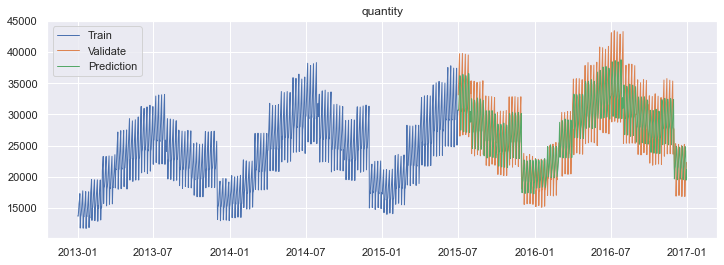

sales_total -- rmse: 26217.0


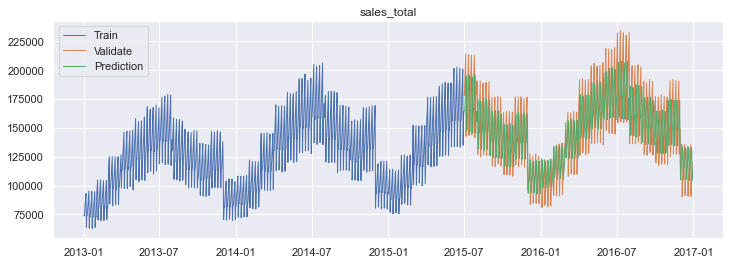

In [71]:
for col in train.columns:
    plot_and_eval(col)

In [72]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal', 
                            target_var = col)

In [73]:
eval_df.sort_values(by='rmse')

model_type   target_var     rmse
0       holts_seasonal     quantity   4869.0
0   104_day_moving_avg     quantity   6101.0
0    52_day_moving_avg     quantity   6563.0
0     4_day_moving_avg     quantity   6592.0
0  last_observed_value     quantity   6621.0
0   30d moving average     quantity   6954.0
0    12_day_moving_avg     quantity   6992.0
0    26_day_moving_avg     quantity   7004.0
0       simple_average     quantity   7378.0
0      holts_optimized     quantity   8225.0
0       holts_seasonal  sales_total  26217.0
0   104_day_moving_avg  sales_total  32803.0
0    52_day_moving_avg  sales_total  35322.0
0  last_observed_value  sales_total  35402.0
0     4_day_moving_avg  sales_total  35515.0
0   30d moving average  sales_total  37378.0
0    26_day_moving_avg  sales_total  37640.0
0    12_day_moving_avg  sales_total  37644.0
0       simple_average  sales_total  39664.0
0      holts_optimized  sales_total  44226.0

Our best implementation of Holt's Seasonal Trend is significantly outperforming all other models made thus far.

### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence.

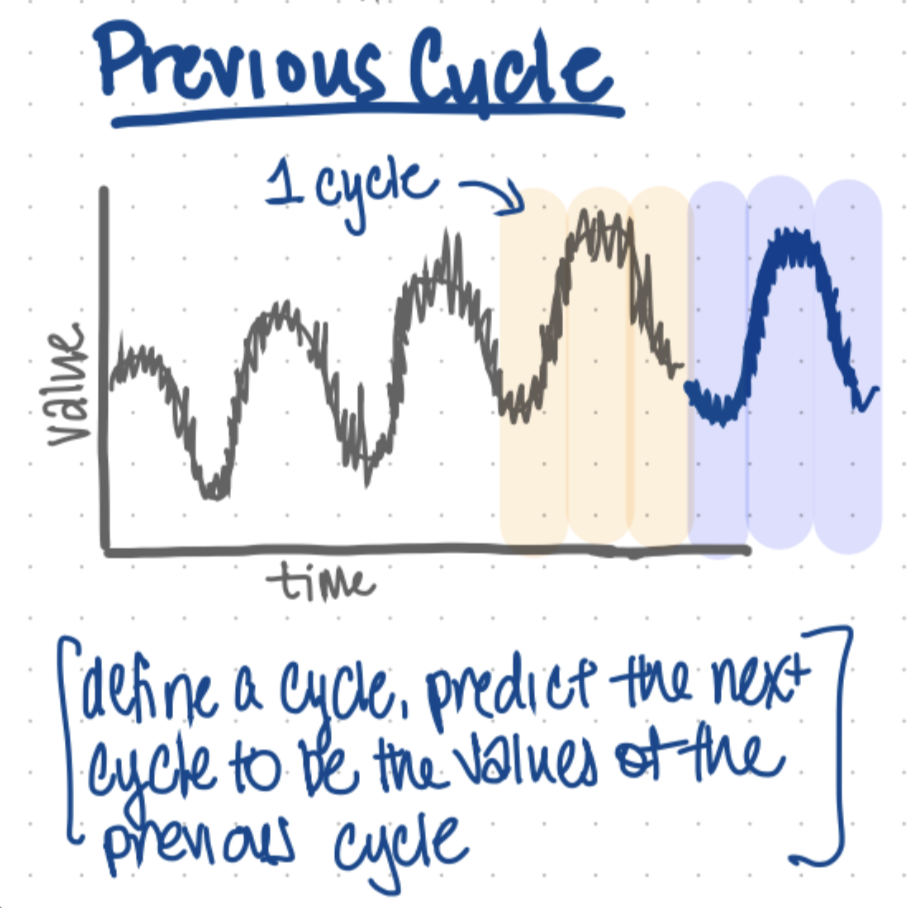

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [74]:
train.tail(1)

quantity  sales_total
sale_date                        
2015-07-01     30703     164573.2

In [75]:
# split it up by year
train = df_resampled.loc[:'2015']
validate = df_resampled.loc['2016']
test = df_resampled.loc['2017']

**Make Predictions**

In [76]:
train.loc['2015']

quantity  sales_total
sale_date                        
2015-01-01     17226     92586.37
2015-01-02     18719    101119.52
2015-01-03     19798    106494.05
2015-01-04     21101    113745.51
2015-01-05     14235     76800.69
...              ...          ...
2015-12-27     23268    125125.86
2015-12-28     15569     84297.45
2015-12-29     18403     98602.75
2015-12-30     18191     97773.10
2015-12-31     19377    103969.42

[365 rows x 2 columns]

In [77]:
train.diff(365).mean()

quantity        2185.813699
sales_total    11751.250493
dtype: float64

In [78]:
# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015.
yhat_df = train.loc['2015'] + train.diff(365).mean()

# set yhat_df to index of validate
yhat_df.index = validate.index

In [79]:
yhat_df.head()

quantity    sales_total
sale_date                              
2016-01-01  19411.813699  104337.620493
2016-01-02  20904.813699  112870.770493
2016-01-03  21983.813699  118245.300493
2016-01-04  23286.813699  125496.760493
2016-01-05  16420.813699   88551.940493

**Plot and Evaluate**

quantity -- rmse: 5223.0


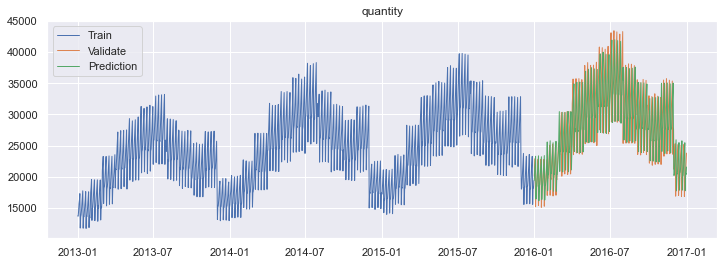

sales_total -- rmse: 28087.0


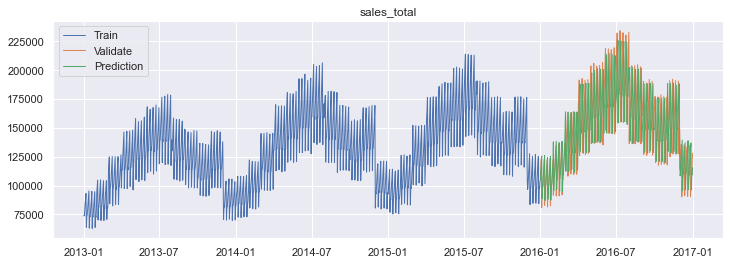

In [80]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

## Conclusion

Which model did the best? 

In [81]:
eval_df.sort_values(by='rmse')

model_type   target_var     rmse
0       holts_seasonal     quantity   4869.0
0        previous year     quantity   5223.0
0   104_day_moving_avg     quantity   6101.0
0    52_day_moving_avg     quantity   6563.0
0     4_day_moving_avg     quantity   6592.0
0  last_observed_value     quantity   6621.0
0   30d moving average     quantity   6954.0
0    12_day_moving_avg     quantity   6992.0
0    26_day_moving_avg     quantity   7004.0
0       simple_average     quantity   7378.0
0      holts_optimized     quantity   8225.0
0       holts_seasonal  sales_total  26217.0
0        previous year  sales_total  28087.0
0   104_day_moving_avg  sales_total  32803.0
0    52_day_moving_avg  sales_total  35322.0
0  last_observed_value  sales_total  35402.0
0     4_day_moving_avg  sales_total  35515.0
0   30d moving average  sales_total  37378.0
0    26_day_moving_avg  sales_total  37640.0
0    12_day_moving_avg  sales_total  37644.0
0       simple_average  sales_total  39664.0
0      holts_optimized  sales_total  44226.0

In [82]:
sales_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

quantity_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == sales_total_min_rmse) | 
         (eval_df.rmse == quantity_min_rmse))]

model_type   target_var     rmse
0  holts_seasonal     quantity   4869.0
0  holts_seasonal  sales_total  26217.0

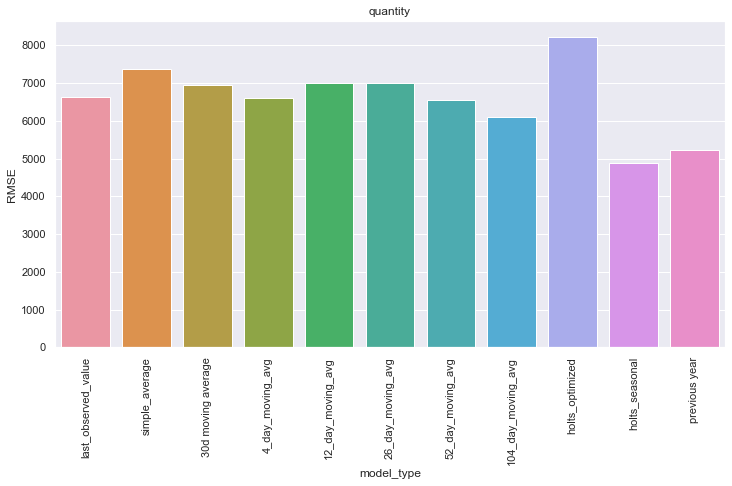

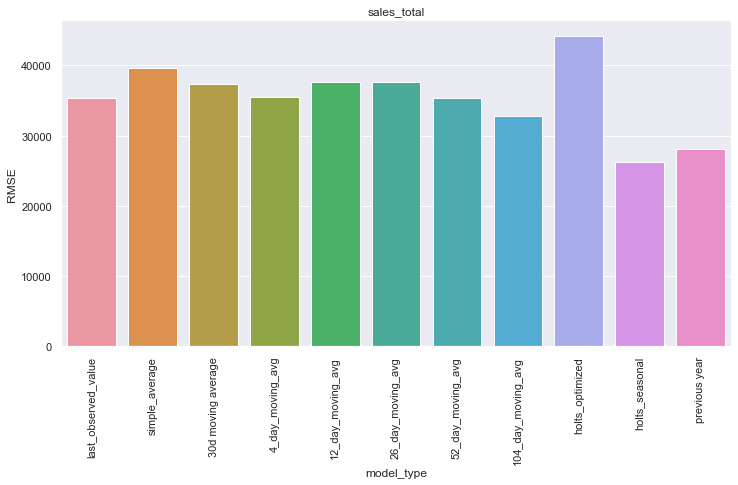

In [83]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x=x, y=y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.show()

# Performance on Test

Now that we have identified our one best model for each target variable, we can evaluate its peformance on our test data. As a reminder, `.forecast()` allows us to make predictions, but the method always starts after the end of the training data. To get to the test data, we will need to increase the number of periods being predicted to be equal to the combined periods of validate and test. 

We altered our train-validate-test split to perform the previous cycle approach. Let's reset to the original train-validate-test split.

In [84]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]
train.shape, validate.shape, test.shape

((912, 2), (547, 2), (366, 2))

In [85]:
yhat_df = pd.DataFrame({'sales_total': hsts['sales_total']['hst_fit_1'].forecast(validate.shape[0] + test.shape[0] + 1),
                           'quantity': hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + test.shape[0] + 1)})
yhat_df

sales_total      quantity
2015-07-02  164609.196455  30633.609157
2015-07-03  165680.392742  30824.375920
2015-07-04  174895.237519  32601.133135
2015-07-05  184376.468086  34413.198903
2015-07-06  194915.370570  36222.829247
...                   ...           ...
2017-12-27  144433.497246  27040.540472
2017-12-28  140958.207561  26305.078664
2017-12-29  116294.685896  21673.991145
2017-12-30  125186.623280  23349.790128
2017-12-31  126939.748466  23735.332011

[914 rows x 2 columns]

The original test set started on 2016-12-31, so we can slice out that portion from our `yhat_df`:

In [86]:
yhat_df = yhat_df['2016-12-31':]

In [87]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [88]:
eval_df.sort_values('rmse')

model_type   target_var     rmse
0       holts_seasonal     quantity   4869.0
0        previous year     quantity   5223.0
0   104_day_moving_avg     quantity   6101.0
0    52_day_moving_avg     quantity   6563.0
0     4_day_moving_avg     quantity   6592.0
0  last_observed_value     quantity   6621.0
0   30d moving average     quantity   6954.0
0    12_day_moving_avg     quantity   6992.0
0    26_day_moving_avg     quantity   7004.0
0       simple_average     quantity   7378.0
0      holts_optimized     quantity   8225.0
0       holts_seasonal  sales_total  26217.0
0        previous year  sales_total  28087.0
0   104_day_moving_avg  sales_total  32803.0
0    52_day_moving_avg  sales_total  35322.0
0  last_observed_value  sales_total  35402.0
0     4_day_moving_avg  sales_total  35515.0
0   30d moving average  sales_total  37378.0
0    26_day_moving_avg  sales_total  37640.0
0    12_day_moving_avg  sales_total  37644.0
0       simple_average  sales_total  39664.0
0      holts_optimized  sales_total  44226.0

FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-sales total:  29973.235168423114
rmse-quantity:  5600.367125634174


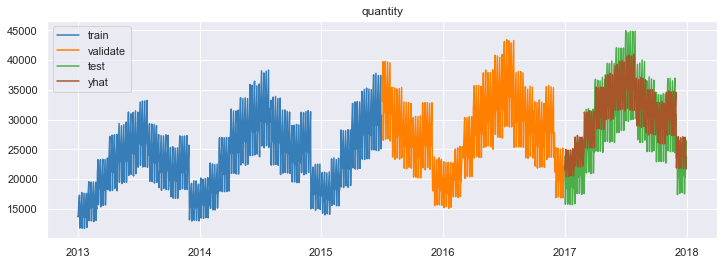

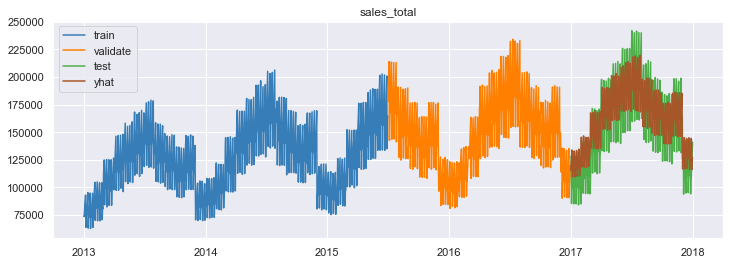

In [89]:
rmse_sales_total = sqrt(mean_squared_error(test['sales_total'], 
                                       yhat_df['sales_total']))

rmse_quantity = sqrt(mean_squared_error(test['quantity'], 
                                       yhat_df['quantity']))

print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-sales total: ', rmse_sales_total)
print('rmse-quantity: ', rmse_quantity)
for col in train.columns:
    final_plot(col)

Our RMSE of our final model did get noticably worse on the test data. Its possible that while the performance of the model starts high, it degrades the further out it projects. Let's take a look at what a projection into 2018 would look like.

## Forcasting Into Future

Predicting 2018 simply requires us to extend the value passed to `.forecast()` by an additional 365 periods and then slicing out what we want:

In [90]:
forecast = pd.DataFrame({'sales_total': hsts['sales_total']['hst_fit_1'].forecast(validate.shape[0] + test.shape[0] + 1 + 365),
                           'quantity': hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + test.shape[0] + 1 + 365)})
# how does forecast look

In [91]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

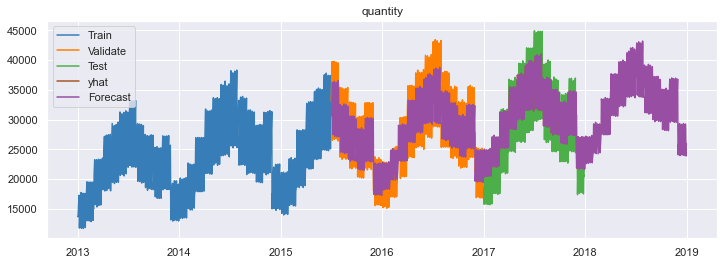

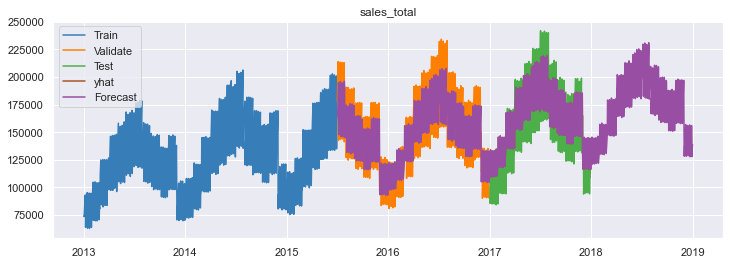

In [92]:
for col in train.columns:
    final_plot(col)

This data set was made of synthetic data with a clear and observable pattern. It allows us to observe the risk of long term performance degredation. While `Holt's Seasonal Trend` outperformed `Previous Cycle` on validate, `Previous Cycle` would have probably been the best model to use. `Holt's Seasonal Trend` is failing to demonstrate the higher maximum value in each subsequent cycle. 

>**However, I can be confident in this claim because I have atypical knowledge that this data is extremely predictable. Real data is rarely as reliable, and conclusions are rarely as clear as the example we have shown here.**

Forecasting is an art as much as it is a science, as the environment that created the values of our historical data may be very different from the environment that creates future values. 

>**"It's tough to make predictions, especially about the future." - Yogi Berra**

## Further Resources
- Modeling with [SARIMAX](https://ds.codeup.com/timeseries/sarimax/)
- Modeling with [SVR](https://ds.codeup.com/timeseries/svr/)
- The [Prophet model](https://facebook.github.io/prophet/docs/installation.html#installation-in-python) from Facebook

## Bonus: Time Series Regression

In [93]:
train_reg = train[['sales_total']]
train_reg

sales_total
sale_date              
2013-01-01     73844.01
2013-01-02     73570.58
2013-01-03     78169.48
2013-01-04     84467.73
2013-01-05     87621.85
...                 ...
2015-06-27    189096.47
2015-06-28    201002.82
2015-06-29    134932.08
2015-06-30    158904.06
2015-07-01    164573.20

[912 rows x 1 columns]

In [94]:
# Function to create lag features
def create_lag_features(data, target_col, num_lags):
    for lag in range(1, num_lags + 1):
        data[f'{target_col}_lag_{lag}'] = data[target_col].shift(lag)
    return data

# Number of lag features to create
num_lags = 30

# Create lag features for the target column
train_reg = create_lag_features(train_reg, 'sales_total', num_lags)

# Display the DataFrame with lag features
train_reg

sales_total  sales_total_lag_1  sales_total_lag_2  \
sale_date                                                       
2013-01-01     73844.01                NaN                NaN   
2013-01-02     73570.58           73844.01                NaN   
2013-01-03     78169.48           73570.58           73844.01   
2013-01-04     84467.73           78169.48           73570.58   
2013-01-05     87621.85           84467.73           78169.48   
...                 ...                ...                ...   
2015-06-27    189096.47          179897.19          166360.76   
2015-06-28    201002.82          189096.47          179897.19   
2015-06-29    134932.08          201002.82          189096.47   
2015-06-30    158904.06          134932.08          201002.82   
2015-07-01    164573.20          158904.06          134932.08   

            sales_total_lag_3  sales_total_lag_4  sales_total_lag_5  \
sale_date                                                             
2013-01-01                NaN                NaN                NaN   
2013-01-02                NaN                NaN                NaN   
2013-01-03                NaN                NaN                NaN   
2013-01-04           73844.01                NaN                NaN   
2013-01-05           73570.58           73844.01                NaN   
...                       ...                ...                ...   
2015-06-27          156645.50          156880.32          133584.49   
2015-06-28          166360.76          156645.50          156880.32   
2015-06-29          179897.19          166360.76          156645.50   
2015-06-30          189096.47          179897.19          166360.76   
2015-07-01          201002.82          189096.47          179897.19   

            sales_total_lag_6  sales_total_lag_7  sales_total_lag_8  \
sale_date                                                             
2013-01-01                NaN                NaN                NaN   
2013-01-02                NaN                NaN                NaN   
2013-01-03                NaN                NaN                NaN   
2013-01-04                NaN                NaN                NaN   
2013-01-05                NaN                NaN                NaN   
...                       ...                ...                ...   
2015-06-27          201912.73          190046.70          178185.72   
2015-06-28          133584.49          201912.73          190046.70   
2015-06-29          156880.32          133584.49          201912.73   
2015-06-30          156645.50          156880.32          133584.49   
2015-07-01          166360.76          156645.50          156880.32   

            sales_total_lag_9  ...  sales_total_lag_21  sales_total_lag_22  \
sale_date                      ...                                           
2013-01-01                NaN  ...                 NaN                 NaN   
2013-01-02                NaN  ...                 NaN                 NaN   
2013-01-03                NaN  ...                 NaN                 NaN   
2013-01-04                NaN  ...                 NaN                 NaN   
2013-01-05                NaN  ...                 NaN                 NaN   
...                       ...  ...                 ...                 ...   
2015-06-27          167603.75  ...           189292.74           179332.67   
2015-06-28          178185.72  ...           201671.16           189292.74   
2015-06-29          190046.70  ...           133690.57           201671.16   
2015-06-30          201912.73  ...           156664.26           133690.57   
2015-07-01          133584.49  ...           156546.04           156664.26   

            sales_total_lag_23  sales_total_lag_24  sales_total_lag_25  \
sale_date                                                                
2013-01-01                 NaN                 NaN                 NaN   
2013-01-02                 NaN                 NaN                 NaN   
2013-01

In [95]:
train_reg = train_reg.dropna()
train_reg

sales_total  sales_total_lag_1  sales_total_lag_2  \
sale_date                                                       
2013-01-31     79237.27           72487.88           73552.31   
2013-02-01     94066.76           79237.27           72487.88   
2013-02-02     98943.56           94066.76           79237.27   
2013-02-03    104593.10           98943.56           94066.76   
2013-02-04     70131.45          104593.10           98943.56   
...                 ...                ...                ...   
2015-06-27    189096.47          179897.19          166360.76   
2015-06-28    201002.82          189096.47          179897.19   
2015-06-29    134932.08          201002.82          189096.47   
2015-06-30    158904.06          134932.08          201002.82   
2015-07-01    164573.20          158904.06          134932.08   

            sales_total_lag_3  sales_total_lag_4  sales_total_lag_5  \
sale_date                                                             
2013-01-31           63666.67           94626.29           88581.11   
2013-02-01           73552.31           63666.67           94626.29   
2013-02-02           72487.88           73552.31           63666.67   
2013-02-03           79237.27           72487.88           73552.31   
2013-02-04           94066.76           79237.27           72487.88   
...                       ...                ...                ...   
2015-06-27          156645.50          156880.32          133584.49   
2015-06-28          166360.76          156645.50          156880.32   
2015-06-29          179897.19          166360.76          156645.50   
2015-06-30          189096.47          179897.19          166360.76   
2015-07-01          201002.82          189096.47          179897.19   

            sales_total_lag_6  sales_total_lag_7  sales_total_lag_8  \
sale_date                                                             
2013-01-31           84285.89           78156.27           72890.91   
2013-02-01           88581.11           84285.89           78156.27   
2013-02-02           94626.29           88581.11           84285.89   
2013-02-03           63666.67           94626.29           88581.11   
2013-02-04           73552.31           63666.67           94626.29   
...                       ...                ...                ...   
2015-06-27          201912.73          190046.70          178185.72   
2015-06-28          133584.49          201912.73          190046.70   
2015-06-29          156880.32          133584.49          201912.73   
2015-06-30          156645.50          156880.32          133584.49   
2015-07-01          166360.76          156645.50          156880.32   

            sales_total_lag_9  ...  sales_total_lag_21  sales_total_lag_22  \
sale_date                      ...                                           
2013-01-31           73579.75  ...            78991.19            75133.92   
2013-02-01           72890.91  ...            84400.09            78991.19   
2013-02-02           78156.27  ...            89426.70            84400.09   
2013-02-03           84285.89  ...            95210.11            89426.70   
2013-02-04           88581.11  ...            63034.32            95210.11   
...                       ...  ...                 ...                 ...   
2015-06-27          167603.75  ...           189292.74           179332.67   
2015-06-28          178185.72  ...           201671.16           189292.74   
2015-06-29          190046.70  ...           133690.57           201671.16   
2015-06-30          201912.73  ...           156664.26           133690.57   
2015-07-01          133584.49  ...           156546.04           156664.26   

            sales_total_lag_23  sales_total_lag_24  sales_total_lag_25  \
sale_date                                                                
2013-01-31            72994.66            63777.54            93093.85   
2013-02-01            75133.92            72994.66            63777.54   
2013-02

In [96]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import math

X_train = train_reg.drop(columns='sales_total')
y_train = train_reg.sales_total

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_train)

# Evaluate the model's performance
rmse = math.sqrt(mean_squared_error(y_train, y_pred))
r2 = r2_score(y_train, y_pred)

print("RMSE:", rmse)
print("R-squared:", r2)

RMSE: 3874.2960436835483
R-squared: 0.9823965262739922


In [97]:
y_val = validate.sales_total
y_val

sale_date
2015-07-02    178036.64
2015-07-03    190981.55
2015-07-04    203696.39
2015-07-05    214040.37
2015-07-06    142584.15
                ...    
2016-12-26     90600.90
2016-12-27    103657.89
2016-12-28    105313.94
2016-12-29    113221.85
2016-12-30    120033.64
Name: sales_total, Length: 547, dtype: float64

In [100]:
X_train[-1:].values

array([[158904.06, 134932.08, 201002.82, 189096.47, 179897.19, 166360.76,
        156645.5 , 156880.32, 133584.49, 201912.73, 190046.7 , 178185.72,
        167603.75, 156624.38, 156814.6 , 133857.34, 202865.41, 190926.06,
        179194.91, 168677.92, 156546.04, 156664.26, 133690.57, 201671.16,
        189292.74, 179332.67, 169145.45, 156515.35, 157292.71, 133597.6 ]])

In [101]:
# Make predictions on the validate data
y_pred = []

# Use the last window of training data as the initial lag features for prediction
window = X_train[-1:].values

# Iterate through the test set and make predictions using the previous predictions as lag features
for i in range(len(y_val)):
    pred = model.predict(window)[0]
    y_pred.append(pred)
    
    # Update the lag features with the current prediction
    window = window[0][1:]
    window = np.append(window, pred)
    window = window.reshape(1, -1)

# Evaluate the model's performance
rmse = sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("Mean Squared Error:", rmse)
print("R-squared:", r2)


Mean Squared Error: 22783286220.711258
R-squared: -493719079865.82324


[]

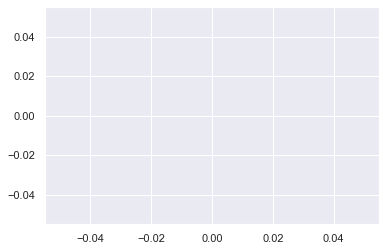

In [102]:
plt.plot()

In [103]:
y_pred

[158009.08470697934,
 159041.82866468088,
 140401.58101440634,
 197836.50764056656,
 186819.38476569758,
 164167.4451798952,
 168199.00305566617,
 164523.86411572085,
 153752.93354189664,
 154232.09086625843,
 198161.98363807262,
 178918.40862632473,
 155627.56463947095,
 174883.5533679503,
 164756.0382682716,
 149090.1943668701,
 173776.62085515022,
 196636.5448131574,
 171332.60167022835,
 147527.70084468165,
 179873.285145792,
 164646.8976407571,
 142552.56592627813,
 194763.05727819283,
 193876.351484637,
 162627.88307076268,
 136667.838698574,
 183327.72241766757,
 170501.34552404878,
 118269.60834507768,
 171851.21821050206,
 174986.07636541128,
 119360.8166451669,
 177545.49361344264,
 214132.31371772342,
 163434.31205364648,
 138347.51957369043,
 193891.99274201307,
 170355.19470327103,
 115899.89402523285,
 197985.69528790808,
 208296.26125000144,
 137903.2805146462,
 149419.83075460326,
 203106.9011708189,
 162340.559939266,
 126163.13370476945,
 212564.77574852604,
 197516.3

In [104]:
y_val

sale_date
2015-07-02    178036.64
2015-07-03    190981.55
2015-07-04    203696.39
2015-07-05    214040.37
2015-07-06    142584.15
                ...    
2016-12-26     90600.90
2016-12-27    103657.89
2016-12-28    105313.94
2016-12-29    113221.85
2016-12-30    120033.64
Name: sales_total, Length: 547, dtype: float64

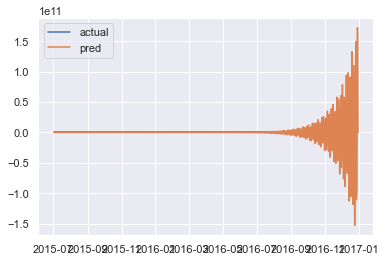

In [105]:
plt.plot(y_val, label='actual')
plt.plot(pd.DataFrame(y_pred, index=y_val.index), label='pred')
plt.legend()

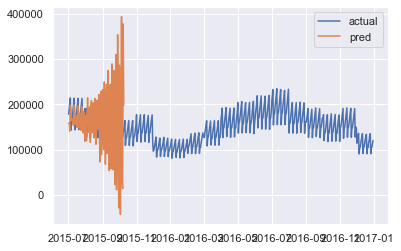

In [113]:
plt.plot(y_val, label='actual')
plt.plot(pd.DataFrame(y_pred, index=y_val.index)[0:100], label='pred')
plt.legend()